## 房价预测

In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow.python.framework import ops

D:\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
ops.reset_default_graph()

#### 观察数据

In [3]:
#对结果影响很小,或者与其他特征相关性较高的特征将被丢弃
to_drop = ['Id','Street','Utilities','Condition2','PoolArea','PoolQC','Fence',
           'YrSold','MoSold','BsmtHalfBath','BsmtFinSF2','GarageQual','MiscVal'
           ,'EnclosedPorch','3SsnPorch','GarageArea','TotRmsAbvGrd','GarageYrBlt'
           ,'BsmtFinType2','BsmtUnfSF','GarageCond'
           ,'GarageFinish','FireplaceQu','BsmtCond','BsmtQual','Alley']

In [4]:
def load_data(path):
    data = pd.read_csv(path)
    #填充None值,因为在特征说明中,None也是某些特征的一个值,所以对于这部分特征的缺失值以None填充
    fill_none = ['MasVnrType','BsmtExposure','GarageType','MiscFeature']
    for col in fill_none:
        data[col].fillna('None',inplace=True);
        
#     #LotFrontage 使用平均数填充
#     mean_LotFrontage = data.mean()['LotFrontage'] 
#     print(mean_LotFrontage)
#     data['LotFrontage'].fillna(mean_LotFrontage,inplace=True)#{'LotFrontage':mean_LotFrontage}

    #对其他缺失值进行填充,离散型特征填充众数,数值型特征填充均值
    na_col = data.dtypes[data.isnull().any()];
    print(na_col)
    for col in na_col.index:
        if na_col[col] != 'object':
            med = data[col].mean();
            print(med)
            data[col].fillna(med,inplace=True);
        else:
            mode = data[col].mode()[0];
            print(mode)
            data[col].fillna(mode,inplace=True);
    
    return data.drop(to_drop,axis=1)

In [5]:
train = load_data('./data/train.csv')

LotFrontage     float64
Alley            object
MasVnrArea      float64
BsmtQual         object
BsmtCond         object
BsmtFinType1     object
BsmtFinType2     object
Electrical       object
FireplaceQu      object
GarageYrBlt     float64
GarageFinish     object
GarageQual       object
GarageCond       object
PoolQC           object
Fence            object
dtype: object
70.04995836802665
Grvl
103.68526170798899
TA
TA
Unf
Unf
SBrkr
Gd
1978.5061638868744
Unf
TA
TA
Gd
MnPrv


In [6]:
train.head(10)

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageCars,PavedDrive,WoodDeckSF,OpenPorchSF,ScreenPorch,MiscFeature,SaleType,SaleCondition,SalePrice
0,60,RL,65.000000,8450,Reg,Lvl,Inside,Gtl,CollgCr,Norm,...,Attchd,2,Y,0,61,0,None,WD,Normal,208500
1,20,RL,80.000000,9600,Reg,Lvl,FR2,Gtl,Veenker,Feedr,...,Attchd,2,Y,298,0,0,None,WD,Normal,181500
2,60,RL,68.000000,11250,IR1,Lvl,Inside,Gtl,CollgCr,Norm,...,Attchd,2,Y,0,42,0,None,WD,Normal,223500
3,70,RL,60.000000,9550,IR1,Lvl,Corner,Gtl,Crawfor,Norm,...,Detchd,3,Y,0,35,0,None,WD,Abnorml,140000
4,60,RL,84.000000,14260,IR1,Lvl,FR2,Gtl,NoRidge,Norm,...,Attchd,3,Y,192,84,0,None,WD,Normal,250000
5,50,RL,85.000000,14115,IR1,Lvl,Inside,Gtl,Mitchel,Norm,...,Attchd,2,Y,40,30,0,Shed,WD,Normal,143000
6,20,RL,75.000000,10084,Reg,Lvl,Inside,Gtl,Somerst,Norm,...,Attchd,2,Y,255,57,0,None,WD,Normal,307000
7,60,RL,70.049958,10382,IR1,Lvl,Corner,Gtl,NWAmes,PosN,...,Attchd,2,Y,235,204,0,Shed,WD,Normal,200000
8,50,RM,51.000000,6120,Reg,Lvl,Inside,Gtl,OldTown,Artery,...,Detchd,2,Y,90,0,0,None,WD,Abnorml,129900
9,190,RL,50.000000,7420,Reg,Lvl,Corner,Gtl,BrkSide,Artery,...,Attchd,1,Y,0,4,0,None,WD,Normal,118000


In [7]:
train_describe = train.describe()
train_describe

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,TotalBsmtSF,...,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,Fireplaces,GarageCars,WoodDeckSF,OpenPorchSF,ScreenPorch,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,1057.429452,...,1.565068,0.382877,2.866438,1.046575,0.613014,1.767123,94.244521,46.660274,15.060959,180921.195890
std,42.300571,22.024023,9981.264932,1.382997,1.112799,30.202904,20.645407,180.569112,456.098091,438.705324,...,0.550916,0.502885,0.815778,0.220338,0.644666,0.747315,125.338794,66.256028,55.757415,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,34900.000000
25%,20.000000,60.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,795.750000,...,1.000000,0.000000,2.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,129975.000000
50%,50.000000,70.049958,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,991.500000,...,2.000000,0.000000,3.000000,1.000000,1.000000,2.000000,0.000000,25.000000,0.000000,163000.000000
75%,70.000000,79.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,164.250000,712.250000,1298.250000,...,2.000000,1.000000,3.000000,1.000000,1.000000,2.000000,168.000000,68.000000,0.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,6110.000000,...,3.000000,2.000000,8.000000,3.000000,3.000000,4.000000,857.000000,547.000000,480.000000,755000.000000


### 计算相关性 大于0 表示正相关，小于0表示负相关

In [8]:
train_corr = train.corr()
train_corr

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,TotalBsmtSF,...,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,Fireplaces,GarageCars,WoodDeckSF,OpenPorchSF,ScreenPorch,SalePrice
MSSubClass,1.000000,-0.357056,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.022895,-0.069836,-0.238518,...,0.131608,0.177354,-0.023438,0.281721,-0.045569,-0.040110,-0.012579,-0.006100,-0.026030,-0.084284
LotFrontage,-0.357056,1.000000,0.306795,0.234196,-0.052820,0.117598,0.082746,0.179283,0.215828,0.363358,...,0.180424,0.048258,0.237023,-0.005805,0.235755,0.269729,0.077106,0.137454,0.037684,0.334901
LotArea,-0.139781,0.306795,1.000000,0.105806,-0.005636,0.014228,0.013788,0.103960,0.214103,0.260833,...,0.126031,0.014259,0.119690,-0.017784,0.271364,0.154871,0.171698,0.084774,0.043160,0.263843
OverallQual,0.032628,0.234196,0.105806,1.000000,-0.091932,0.572323,0.550684,0.410238,0.239666,0.537808,...,0.550600,0.273458,0.101676,-0.183882,0.396765,0.600671,0.238923,0.308819,0.064886,0.790982
OverallCond,-0.059316,-0.052820,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.127788,-0.046231,-0.171098,...,-0.194149,-0.060769,0.012980,-0.087001,-0.023820,-0.185758,-0.003334,-0.032589,0.054811,-0.077856
YearBuilt,0.027850,0.117598,0.014228,0.572323,-0.375983,1.000000,0.592855,0.314745,0.249503,0.391452,...,0.468271,0.242656,-0.070651,-0.174800,0.147716,0.537850,0.224880,0.188686,-0.050364,0.522897
YearRemodAdd,0.040581,0.082746,0.013788,0.550684,0.073741,0.592855,1.000000,0.179186,0.128451,0.291066,...,0.439046,0.183331,-0.040581,-0.149598,0.112581,0.420622,0.205726,0.226298,-0.038740,0.507101
MasVnrArea,0.022895,0.179283,0.103960,0.410238,-0.127788,0.314745,0.179186,1.000000,0.263582,0.362452,...,0.275730,0.200802,0.102417,-0.037364,0.247906,0.363778,0.159349,0.124965,0.061453,0.475241
BsmtFinSF1,-0.069836,0.215828,0.214103,0.239666,-0.046231,0.249503,0.128451,0.263582,1.000000,0.522396,...,0.058543,0.004262,-0.107355,-0.081007,0.260011,0.224054,0.204306,0.111761,0.062021,0.386420
TotalBsmtSF,-0.238518,0.363358,0.260833,0.537808,-0.171098,0.391452,0.291066,0.362452,0.522396,1.000000,...,0.323722,-0.048804,0.050450,-0.068901,0.339519,0.434585,0.232019,0.247264,0.084489,0.613581


In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

In [10]:
%matplotlib inline

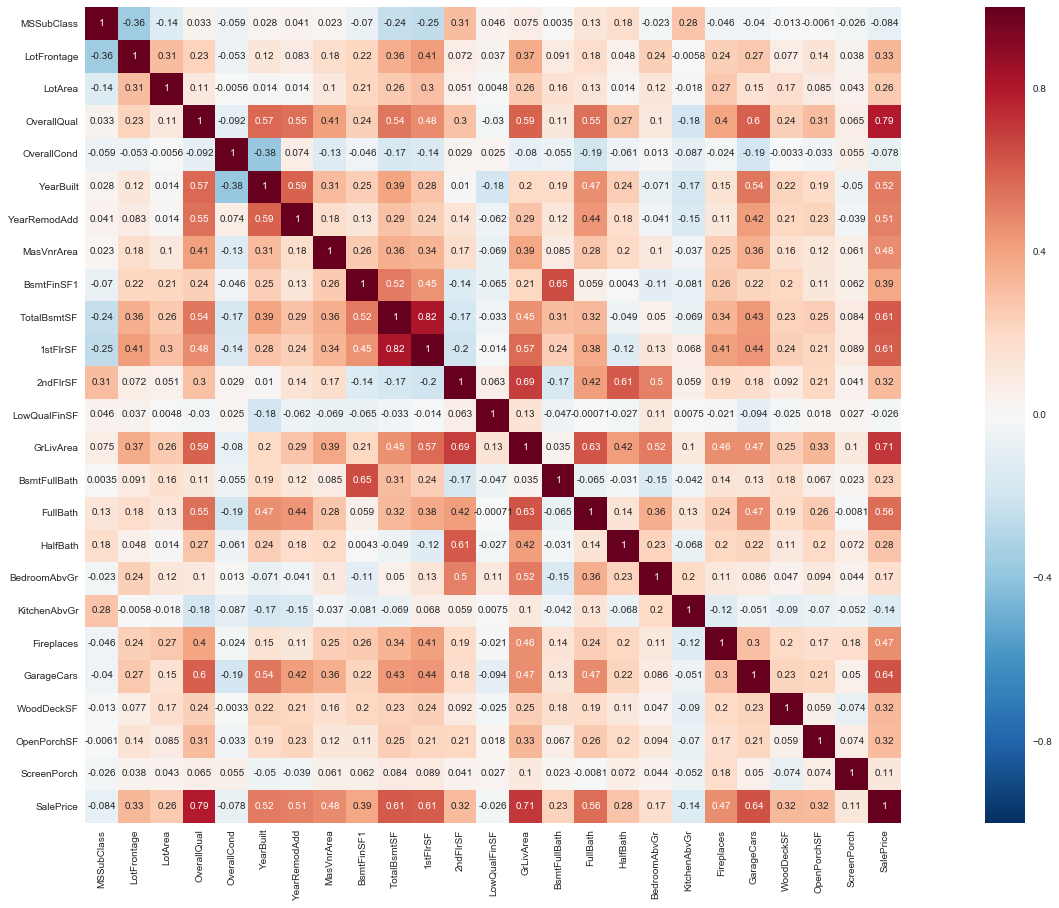

In [11]:
#画出相关性热力图
a = plt.subplots(figsize=(30,15))#调整画布大小
a = sns.heatmap(train_corr, vmin=-1, vmax=1 , annot=True , square=True)#画热力图

In [12]:
feature_columns = []

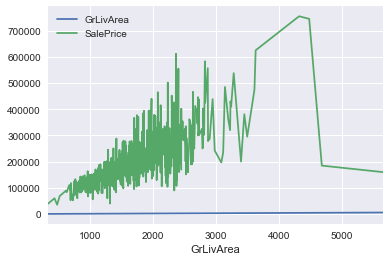

In [13]:
train.groupby('GrLivArea')['GrLivArea','SalePrice'].mean().plot()

In [14]:
# feature_columns.append(tf.feature_column.numeric_column(key='GrLivArea'))

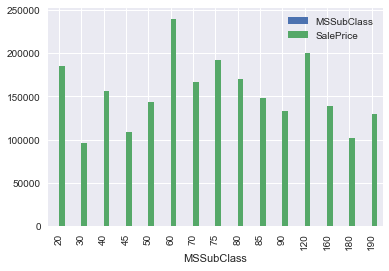

In [15]:
train.groupby('MSSubClass')['MSSubClass','SalePrice'].mean().plot.bar()

In [16]:
# feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(key='MSSubClass',vocabulary_list=[20,30,40,45,50,60,70,80,90,120,160,180,190]))

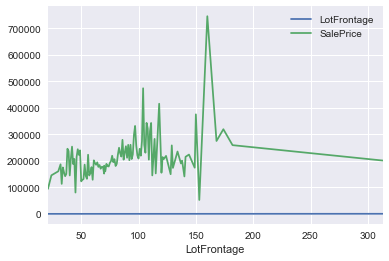

In [17]:
train.groupby('LotFrontage')['LotFrontage','SalePrice'].mean().plot()

In [18]:
# feature_columns.append(tf.feature_column.numeric_column(key='LotFrontage'))

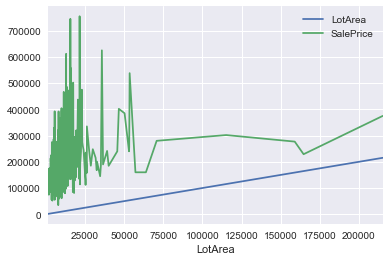

In [19]:
train.groupby('LotArea')['LotArea','SalePrice'].mean().plot()

In [20]:
train_corr.pop('SalePrice')
train_corr

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,TotalBsmtSF,...,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,Fireplaces,GarageCars,WoodDeckSF,OpenPorchSF,ScreenPorch
MSSubClass,1.000000,-0.357056,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.022895,-0.069836,-0.238518,...,0.003491,0.131608,0.177354,-0.023438,0.281721,-0.045569,-0.040110,-0.012579,-0.006100,-0.026030
LotFrontage,-0.357056,1.000000,0.306795,0.234196,-0.052820,0.117598,0.082746,0.179283,0.215828,0.363358,...,0.091481,0.180424,0.048258,0.237023,-0.005805,0.235755,0.269729,0.077106,0.137454,0.037684
LotArea,-0.139781,0.306795,1.000000,0.105806,-0.005636,0.014228,0.013788,0.103960,0.214103,0.260833,...,0.158155,0.126031,0.014259,0.119690,-0.017784,0.271364,0.154871,0.171698,0.084774,0.043160
OverallQual,0.032628,0.234196,0.105806,1.000000,-0.091932,0.572323,0.550684,0.410238,0.239666,0.537808,...,0.111098,0.550600,0.273458,0.101676,-0.183882,0.396765,0.600671,0.238923,0.308819,0.064886
OverallCond,-0.059316,-0.052820,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.127788,-0.046231,-0.171098,...,-0.054942,-0.194149,-0.060769,0.012980,-0.087001,-0.023820,-0.185758,-0.003334,-0.032589,0.054811
YearBuilt,0.027850,0.117598,0.014228,0.572323,-0.375983,1.000000,0.592855,0.314745,0.249503,0.391452,...,0.187599,0.468271,0.242656,-0.070651,-0.174800,0.147716,0.537850,0.224880,0.188686,-0.050364
YearRemodAdd,0.040581,0.082746,0.013788,0.550684,0.073741,0.592855,1.000000,0.179186,0.128451,0.291066,...,0.119470,0.439046,0.183331,-0.040581,-0.149598,0.112581,0.420622,0.205726,0.226298,-0.038740
MasVnrArea,0.022895,0.179283,0.103960,0.410238,-0.127788,0.314745,0.179186,1.000000,0.263582,0.362452,...,0.085055,0.275730,0.200802,0.102417,-0.037364,0.247906,0.363778,0.159349,0.124965,0.061453
BsmtFinSF1,-0.069836,0.215828,0.214103,0.239666,-0.046231,0.249503,0.128451,0.263582,1.000000,0.522396,...,0.649212,0.058543,0.004262,-0.107355,-0.081007,0.260011,0.224054,0.204306,0.111761,0.062021
TotalBsmtSF,-0.238518,0.363358,0.260833,0.537808,-0.171098,0.391452,0.291066,0.362452,0.522396,1.000000,...,0.307351,0.323722,-0.048804,0.050450,-0.068901,0.339519,0.434585,0.232019,0.247264,0.084489


In [21]:

col_type = train.dtypes
col_type['ScreenPorch']

dtype('int64')

In [22]:
feature_columns = []
# train.pop('SaleCondition')
train_x,train_y = train,train.pop('SalePrice')
col_type = train_x.dtypes
for col in col_type.index:
    if col_type[col] == 'object':
#         print('1---------------->',col)
        col_value_couns = train[col].value_counts().index.tolist()
        feature_columns.append(tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list(key=col,vocabulary_list=col_value_couns)))
    else:
#         print('2---------------->',col)
        mean = train_describe[col]['mean']
        std = train_describe[col]['std']
#         print('3---------------->',mean,std)
        feature_columns.append(tf.feature_column.numeric_column(key = col,normalizer_fn=lambda x:(x - mean) / std)) 


In [23]:
feature_columns
# train['BsmtQual'].value_count

[_NumericColumn(key='MSSubClass', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function <lambda> at 0x000000001A93AC80>),
 _IndicatorColumn(categorical_column=_VocabularyListCategoricalColumn(key='MSZoning', vocabulary_list=('RL', 'RM', 'FV', 'RH', 'C (all)'), dtype=tf.string, default_value=-1, num_oov_buckets=0)),
 _NumericColumn(key='LotFrontage', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function <lambda> at 0x000000001239ABF8>),
 _NumericColumn(key='LotArea', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function <lambda> at 0x000000001ABCF510>),
 _IndicatorColumn(categorical_column=_VocabularyListCategoricalColumn(key='LotShape', vocabulary_list=('Reg', 'IR1', 'IR2', 'IR3'), dtype=tf.string, default_value=-1, num_oov_buckets=0)),
 _IndicatorColumn(categorical_column=_VocabularyListCategoricalColumn(key='LandContour', vocabulary_list=('Lvl', 'Bnk', 'HLS', 'Low'), dtype=tf.string, default_value=-1, num_oov_buckets=0)),
 _

In [30]:
def model_fn(features,labels,mode,params):
    
    input_layer = tf.feature_column.input_layer(features=features,feature_columns=params['feature_colums'])
    hiddle_unit = params['hiddle_unit']
    for unit in hiddle_unit:
        input_layer = tf.layers.dense(inputs=input_layer, units=unit,activation=tf.nn.relu,
                        kernel_initializer=tf.random_normal_initializer(),
                                      bias_initializer=tf.constant_initializer(1),
                                      kernel_regularizer = tf.contrib.layers.l1_l2_regularizer(0.5,0.5))
    
    out = tf.layers.dense(inputs=input_layer,units=1,activation=tf.nn.relu)
    
    out_loss = tf.losses.mean_squared_error(labels,out)
    
    loss = tf.add(out_loss,tf.losses.get_regularization_loss())
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        predictions = {
            'class_ids': out[:, tf.newaxis],
            'probabilities': out,
            'logits': logits,
        }
        return tf.estimator.EstimatorSpec(mode, predictions=predictions)
    
     # 评估 返回准确率
    if mode == tf.estimator.ModeKeys.EVAL:
        accuracy = tf.metrics.mean_squared_error(labels=labels,predictions=out,name ='acc_op')
        metrics = {'accuracy':accuracy}
#         tf.summary.scalar(accuracy[1])
        return tf.estimator.EstimatorSpec(mode,loss = loss,eval_metric_ops = metrics)
    
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer =  tf.train.AdamOptimizer(learning_rate=0.01);
        train_op = optimizer.minimize(loss,tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode,loss=loss,train_op = train_op)
        
        
    

In [31]:
params = {'feature_colums':feature_columns,
         'hiddle_unit':[50,5]}
house_regress = tf.estimator.Estimator(model_fn=model_fn,model_dir='./model/',params=params)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': './model/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000000001D50E278>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [33]:
house_regress.train(input_fn=tf.estimator.inputs.pandas_input_fn(x = train_x,y=train_y,shuffle=True,batch_size=128),steps=100)

INFO:tensorflow:Calling model_fn.


ValueError: Shapes (?, 1) and (?,) are incompatible